In [1]:
import scipy as syp
import scipy.special
import numpy as np 

In [2]:
def getConfidence_nonconvex(k,N,beta): 
 # k= Number of support scenarios
 # N= Number of scenarios in the dataset
 # beta= s small confidence parameter (beta=10^-8 means high confidence level) 
    if k == N:
        epsilon=1
    elif k < N:
    #  this is numerically  for high N and k
    #   epsilon=1-(beta./(N.*nchoosek(N,k))).^(1/(N-k));
    #  This expansion is slower but guarantees stability (and numerical accuracy)
        E = (beta*k/N**2)**(1/(N-k))  
        for l in range(k-1):
            Temp = (1/((N-l)/(k-l)))**(1/(N-k))
            E = E*Temp    
            epsilon = 1-E 
    elif k > N:
        print('ERROR: numbber of support constraints k should be k<=N') 
    return epsilon

# EXAMPLE HOW TO USE
#N=10**5 # number of samples 
#sn=300 # number of support constraints
#beta=10**-8 # confidence parameter (small beta means almost cerainty)
#getConfidence_nonconvex(sn,N,beta)

In [21]:
def getConfidence_relaxedConstraints(k,N,bet): 
 # Compute lower and upper bounds on the probability of violation  for future scenarios
 # k = Number of support scenarios (scenarios delta_i for which the optimal design d* leads to a violation g(d*,delta_i)>=0 )
 # N = Number of scenarios in the dataset used to compute the optimal design d*
 # beta = a small confidence parameter (beta=10^-8 means high confidence level)
    alphaL = syp.special.betaincinv(k,N-k+1,bet)
    alphaU = 1- syp.special.betaincinv(N-k+1,k,bet) 
    Temp=np.log(range(k,N+1))
    Temp[0]=0
    #Temp=np.sort(Temp)[::-1]
    CUMSUM=np.cumsum(np.sort(Temp)[::-1])
    CUMSUM[-1]=0
    aux1=np.sort(CUMSUM)[::-1]# auxiliary variables 1
    # auxiliary variables 2 
    Temp=np.log(range(1,N+2-k))
    Temp[-1]=0
    #Temp=np.sort(Temp)[::-1]
    CUMSUM=np.cumsum(np.sort(Temp)[::-1])
    CUMSUM[-1]=0
    aux2=np.sort(CUMSUM)[::-1] 
    Temp=np.log(range(N+1,4*N+1)) 
    Temp=np.sort(Temp)  
    aux3=np.sort(np.cumsum(Temp))  # auxiliary variables 3 
    Temp=np.log(range(N+1,4*N+1) ) 
    Temp=np.sort(Temp)  
    aux3=np.sort(np.cumsum(Temp))  
    Temp=np.log(range(N+1-k,4*N+1-k)) 
    Temp=np.sort(Temp)  
    aux4=np.sort(np.cumsum(Temp))  # auxiliary variables 4 
    coeffs1 = aux2-aux1 
    coeffs2= aux3-aux4 
    t1 = 1-alphaL 
    t2 = 1   
    M1=np.sort(range(0,N-k+1))[::-1]
    M2=range(1,3*N+1)
    poly1 = 1+bet/(2*N)-bet/(2*N)*np.sum(np.exp(coeffs1-M1*np.log(t1))) -bet/(6*N)*np.sum(np.exp(coeffs2 +M2*np.log(t1))) 
    poly2 = 1+bet/(2*N)-bet/(2*N)*np.sum(np.exp(coeffs1-M1*np.log(t2))) -bet/(6*N)*np.sum(np.exp(coeffs2 +M2*np.log(t2)))
    # Now it calculates the lower and upper bounds
    if ((poly1*poly2) > 0):
        epsL = 0;
    else:
        while t2-t1 > 1e-10:
            t = (t1+t2)/2;
            polyt = 1+bet/(2*N)-bet/(2*N)*np.sum(np.exp(coeffs1 - M1*np.log(t)))  -bet/(6*N)*np.sum(np.exp(coeffs2 + M2*np.log(t)))  
            if polyt > 0:
                t1=t
            else:
                t2=t 
        epsL = 1-t2
    t1 = 0
    t2 = 1-alphaU
    poly2 = 1+bet/(2*N)-bet/(2*N)*np.sum(np.exp(coeffs1-M1*np.log(t2))) -bet/(6*N)*np.sum(np.exp(coeffs2 + M2*np.log(t2))) 

    while t2-t1 > 1e-10:
            t = (t1+t2)/2  
            polyt = 1+bet/(2*N)-bet/(2*N)*np.sum(np.exp(coeffs1 - M1*np.log(t)))  -bet/(6*N)*np.sum(np.exp(coeffs2 + M2*np.log(t)))
            if polyt > 0:
                t2=t
            else:
                t1=t  
            epsU = 1-t1
    #epsilon=(epsL,epsU) # resulting lower and upper bound on the violation probability
    return (epsL,epsU)

# EXAMPLE HOW TO USE
beta=10**-6 
N=10000
k=6610
Out1 , Out2 = getConfidence_relaxedConstraints(k,N,beta)
print([Out1,Out2])

[0.6309844763295013, 0.6894254477459933]


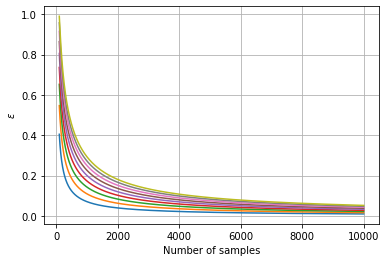

In [19]:
import matplotlib.pyplot as plt 
beta=10**-6
SN=100
Nrange=range(SN,SN*100)
SNrange=range(10,SN,10) 
for k in SNrange:
    Epsilon_nnconvex = [getConfidence_nonconvex(k,i,beta) for i in Nrange] 
    plt.plot(Nrange,Epsilon_nnconvex)   
    
plt.xlabel('Number of samples')
plt.ylabel('$\epsilon$')
plt.grid(True) 

In [ ]:
beta=10**-6 
SN=100
Nrange=range(SN,SN*10)
SNrange=range(10,SN,10) 
for k in SNrange: 
    Epsilon_lw=[] 
    Epsilon_up=[]
    for i in Nrange: 
   # Out1 ,Out2 =  [getConfidence_relaxedConstraints(k,i,beta) for i in Nrange]  
        Out1 ,Out2 =  getConfidence_relaxedConstraints(k,i,beta)
        Epsilon_lw += [Out1]
        Epsilon_up += [Out2]   
    plt.plot(Nrange,Epsilon_lw,'b')
    plt.plot(Nrange,Epsilon_up,'r')
    
plt.xlabel('Number of samples')
plt.ylabel('$\epsilon$')
plt.grid(True) 